In [1]:
import numpy as np
import pandas as pd
import shap
import time
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def type_selector(df):

    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique())< 20
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def feature_selector(X):
    continuous_columns = X.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(X[feature].unique())< 20
    ]
    categorical_columns = X.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    dummies_features = pd.get_dummies(X[categorical_columns])
    X = pd.concat([X, dummies_features], axis=1)
    dummies_features = dummies_features.columns.tolist()
    X = X.drop(categorical_columns, axis=1)

    return X

In [4]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgbm.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = catb.Pool(x_train, y_train)
        dvalid = catb.Pool(x_valid, y_valid)

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=100
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, encoders, oof_preds

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
applications_history = pd.read_csv('./data/applications_history.csv')

In [7]:
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash
...,...,...,...
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash


In [8]:
applications_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [9]:
applications_history.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [10]:
categorical_columns,continuous_columns = type_selector(applications_history)

In [11]:
applications_history = applications_history.rename(columns={ applications_history.columns[1]: "APPLICATION_NUMBER_AP_HIST" })

In [12]:
def app_history_features_gen(df):
    df['AMOUNT_ANNUITY_and_DECISION'] = df['AMOUNT_ANNUITY']/df['DAYS_DECISION']
    df['AMOUNT_ANNUITY_and_DAYS_LAST_DUE_1ST_VERSION'] = df['AMOUNT_ANNUITY']/df['DAYS_LAST_DUE_1ST_VERSION']
    df['AMOUNT_ANNUITY_and_DAYS_FIRST_DRAWING'] = df['AMOUNT_ANNUITY']/df['DAYS_FIRST_DRAWING']
    df['AMOUNT_ANNUITY_and_DAYS_DAYS_TERMINATION'] = df['AMOUNT_ANNUITY']/df['DAYS_TERMINATION']
    df['AMOUNT_ANNUITY_and_AMOUNT_PAYMENT'] = df['AMOUNT_ANNUITY'] / df['AMOUNT_PAYMENT']
    df['AMOUNT_ANNUITY_and_AMOUNT_GOODS_PAYMENT'] = df['AMOUNT_ANNUITY'] / df['AMOUNT_GOODS_PAYMENT']
    df['AMOUNT_ANNUITY_and_AMOUNT_AMOUNT_CREDIT'] = df['AMOUNT_ANNUITY'] / df['AMOUNT_CREDIT']
    df['AMOUNT_ANNUITY_and_AMT_APPLICATION'] = df['AMOUNT_ANNUITY'] / df['AMT_APPLICATION']
    df['AMOUNT_ANNUITY_and_DAYS_FIRST_DUE'] = df['AMOUNT_ANNUITY'] / df['DAYS_FIRST_DUE']
    df['AMOUNT_ANNUITY_and_DAYS_LAST_DUE'] = df['AMOUNT_ANNUITY'] / df['DAYS_LAST_DUE']
    
    return df
    

In [13]:
def app_history_clean_data(df):
    df['DAYS_TERMINATION'] = np.where(df['DAYS_TERMINATION'] == 365243.0, 0, df['DAYS_TERMINATION'])
    df['DAYS_LAST_DUE_1ST_VERSION'] = np.where(df['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0, 0, df['DAYS_LAST_DUE_1ST_VERSION'])
    df['DAYS_FIRST_DRAWING'] = np.where(df['DAYS_FIRST_DRAWING'] == 365243.0, 0, df['DAYS_FIRST_DRAWING'])
    df['DAYS_FIRST_DUE'] = np.where(df['DAYS_FIRST_DUE'] == 365243.0, 0, df['DAYS_FIRST_DUE'])
    df['DAYS_LAST_DUE'] = np.where(df['DAYS_LAST_DUE'] == 365243.0, 0, df['DAYS_LAST_DUE'])
    
    return df
    

In [14]:
app_history_clean_data(applications_history)
app_history_features_gen(applications_history)
applications_history = applications_history.replace([-np.inf, np.inf], [np.nan, np.nan])

In [15]:
def group_by_stat(df,features_list):
    
    for item in features_list:
        df[item+"_mean-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_AP_HIST'].transform('mean')
        df[item+"_median-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_AP_HIST'].transform('median')
        df[item+"_std-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_AP_HIST'].transform('std')
        df[item+"_count_"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_AP_HIST'].transform('count')
        df[item+"_min-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_AP_HIST'].transform('min')
        df[item+"_max_"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_AP_HIST'].transform('max')
    
    return df

In [16]:
categorical_columns,continuous_columns = type_selector(applications_history.drop('APPLICATION_NUMBER_AP_HIST',1))

In [17]:
def freq_encoder(df,features_list):
    
    for item in features_list:
        freq_encoder = df[item].value_counts(normalize=True)
        df[item+"_freq_enc"] = df[item].map(freq_encoder)
    
    return df

In [18]:
categorical_columns,continuous_columns = type_selector(applications_history)

In [19]:
train_freq_encoder = freq_encoder(applications_history, categorical_columns+continuous_columns)

In [20]:
app_history_grouped_by_stat= group_by_stat(train_freq_encoder,categorical_columns+continuous_columns)

In [21]:
app_history_grouped_by_stat

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER_AP_HIST,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_std-APPLICATION_NUMBER,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_count_APPLICATION_NUMBER,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_min-APPLICATION_NUMBER,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_max_APPLICATION_NUMBER,AMOUNT_PAYMENT_mean-APPLICATION_NUMBER,AMOUNT_PAYMENT_median-APPLICATION_NUMBER,AMOUNT_PAYMENT_std-APPLICATION_NUMBER,AMOUNT_PAYMENT_count_APPLICATION_NUMBER,AMOUNT_PAYMENT_min-APPLICATION_NUMBER,AMOUNT_PAYMENT_max_APPLICATION_NUMBER
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,NaN,NaN,NaN,NaN,1.236015e+08,123601645.5,102829.150057,369854.0,123423341.0,123779594.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,49568678,123675354,NaN,14704.290,267295.5,311400.0,0.0,267295.5,Approved,544,...,NaN,NaN,NaN,NaN,1.236015e+08,123601645.5,102829.150057,369854.0,123423341.0,123779594.0
1670210,49625245,123657974,NaN,6622.020,87750.0,64291.5,29250.0,87750.0,Approved,1694,...,155918.459465,2.0,123437472.0,123657974.0,1.235981e+08,123596974.0,105723.344981,247.0,123424547.0,123774478.0
1670211,49927846,123572883,NaN,11520.855,105237.0,102523.5,10525.5,105237.0,Approved,1488,...,NaN,1.0,123572883.0,123572883.0,1.235871e+08,123580347.5,90562.744259,38.0,123438255.0,123768418.0
1670212,50053796,123723656,Cash,18821.520,180000.0,191880.0,NaN,180000.0,Approved,1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#data_grouped = applications_history.groupby('APPLICATION_NUMBER').agg(['count', 'median'])

In [23]:
#app_history_grouped = pd.merge(applications_history, data_grouped, how='left', on = 'APPLICATION_NUMBER')
#app_history_features_gen(app_history_grouped)

In [24]:
app_history_grouped_by_stat = app_history_grouped_by_stat.rename(columns={ app_history_grouped_by_stat.columns[1]: "APPLICATION_NUMBER" })

In [25]:
#reduce_mem_usage(app_history_grouped_by_stat)

In [26]:
app_history_grouped_by_stat

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_std-APPLICATION_NUMBER,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_count_APPLICATION_NUMBER,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_min-APPLICATION_NUMBER,AMOUNT_ANNUITY_and_AMOUNT_PAYMENT_max_APPLICATION_NUMBER,AMOUNT_PAYMENT_mean-APPLICATION_NUMBER,AMOUNT_PAYMENT_median-APPLICATION_NUMBER,AMOUNT_PAYMENT_std-APPLICATION_NUMBER,AMOUNT_PAYMENT_count_APPLICATION_NUMBER,AMOUNT_PAYMENT_min-APPLICATION_NUMBER,AMOUNT_PAYMENT_max_APPLICATION_NUMBER
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,NaN,NaN,NaN,NaN,1.236015e+08,123601645.5,102829.150057,369854.0,123423341.0,123779594.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,49568678,123675354,NaN,14704.290,267295.5,311400.0,0.0,267295.5,Approved,544,...,NaN,NaN,NaN,NaN,1.236015e+08,123601645.5,102829.150057,369854.0,123423341.0,123779594.0
1670210,49625245,123657974,NaN,6622.020,87750.0,64291.5,29250.0,87750.0,Approved,1694,...,155918.459465,2.0,123437472.0,123657974.0,1.235981e+08,123596974.0,105723.344981,247.0,123424547.0,123774478.0
1670211,49927846,123572883,NaN,11520.855,105237.0,102523.5,10525.5,105237.0,Approved,1488,...,NaN,1.0,123572883.0,123572883.0,1.235871e+08,123580347.5,90562.744259,38.0,123438255.0,123768418.0
1670212,50053796,123723656,Cash,18821.520,180000.0,191880.0,NaN,180000.0,Approved,1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train = pd.merge(train, app_history_grouped_by_stat, how='left', on = ['APPLICATION_NUMBER'])
test = pd.merge(test, app_history_grouped_by_stat, how='left', on = ['APPLICATION_NUMBER'])

In [28]:
train_featured = feature_selector(train.drop('TARGET', 1))
test = feature_selector(test)
train_featured['TARGET'] = train['TARGET']

In [29]:
#app_history_grouped_by_stat.to_csv('app_history_grouped_by_stat.csv', index=False)

In [30]:
#train_featured.to_csv('train_app_hist.csv', index=False)
#test.to_csv('test_app_hist.csv', index=False)


In [31]:
import re
train_featured = train_featured.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_featured.drop(["TARGET"],1), 
                                                    train_featured['TARGET'], random_state=0)

In [33]:
data = pd.DataFrame()

In [34]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.03,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 5,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [35]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.621823	valid_1's auc: 0.567736
Early stopping, best iteration is:
[253]	training's auc: 0.635803	valid_1's auc: 0.570843


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.03, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


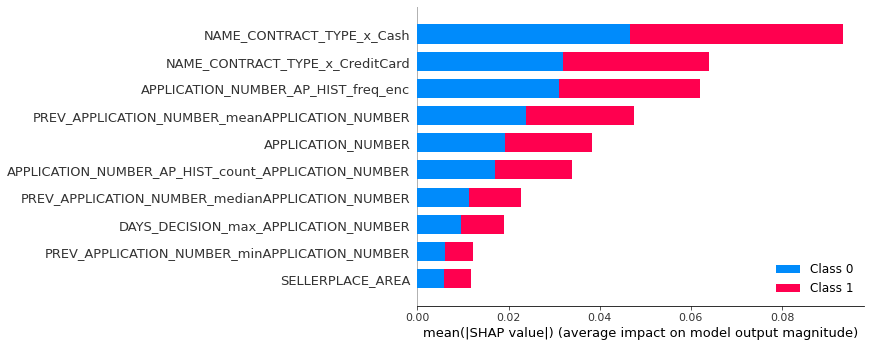

In [37]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

In [38]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

201    18416.501102
202    12620.593389
43     12292.904883
156     9380.453696
0       7520.537186
           ...     
29         0.000000
215        0.000000
214        0.000000
213        0.000000
217        0.000000
Name: feature_importance_vals, Length: 272, dtype: float64

In [39]:
feature_importance['feature_importance_vals'].mean()

549.1293671094207

NameError: name 'asd' is not defined

In [42]:
feature_importance.loc[feature_importance['feature_importance_vals'] > 549]

,col_name,feature_importance_vals
201,NAME_CONTRACT_TYPE_x_Cash,18416.501102
202,NAME_CONTRACT_TYPE_x_CreditCard,12620.593389
43,APPLICATION_NUMBER_AP_HIST_freq_enc,12292.904883
156,PREV_APPLICATION_NUMBER_meanAPPLICATION_NUMBER,9380.453696
0,APPLICATION_NUMBER,7520.537186
168,APPLICATION_NUMBER_AP_HIST_count_APPLICATION_N...,6684.581819
157,PREV_APPLICATION_NUMBER_medianAPPLICATION_NUMBER,4461.307366
102,DAYS_DECISION_max_APPLICATION_NUMBER,3745.770138
158,PREV_APPLICATION_NUMBER_minAPPLICATION_NUMBER,2395.881367
8,SELLERPLACE_AREA,2295.533718


In [43]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 549]

In [44]:
feature_importance = feature_importance['col_name'].tolist()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_featured[feature_importance], 
                                                    train_featured['TARGET'], random_state=0)

In [46]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.05,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 5,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [47]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	training's auc: 0.625779	valid_1's auc: 0.577403


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [48]:
test

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walkin,NAME_PRODUCT_TYPE_xsell,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,123724268,49492051.0,NaN,0.0,0.0,NaN,NaN,446.0,-1.0,NaN,...,0,1,1,0,0,1,0,0,0,0
1,123724268,48519927.0,22500.000,450000.0,450000.0,NaN,450000.0,446.0,-1.0,0.0,...,0,0,0,0,1,1,0,0,0,0
2,123724268,48498761.0,11175.615,122031.0,122031.0,0.0,122031.0,720.0,150.0,12.0,...,1,0,1,0,0,0,0,1,0,0
3,123724268,50007168.0,NaN,0.0,0.0,NaN,NaN,446.0,-1.0,NaN,...,0,1,1,0,0,1,0,0,0,0
4,123456549,49786843.0,47870.775,540000.0,684252.0,NaN,540000.0,390.0,-1.0,24.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782449,123631557,49852228.0,26027.685,315000.0,404833.5,NaN,315000.0,1140.0,-1.0,24.0,...,0,0,0,0,1,0,0,0,0,1
782450,123631557,49193349.0,30734.370,495000.0,563607.0,NaN,495000.0,723.0,-1.0,42.0,...,0,0,0,0,1,0,1,0,0,0
782451,123631557,49821544.0,25857.000,450000.0,450000.0,NaN,450000.0,723.0,-1.0,36.0,...,0,0,0,0,1,0,1,0,0,0
782452,123433260,48825740.0,2919.870,35388.0,21888.0,13500.0,35388.0,2497.0,10.0,10.0,...,1,0,1,0,0,0,1,0,0,0


In [49]:
train = train_featured[feature_importance].groupby('APPLICATION_NUMBER').mean()
test = test[feature_importance].groupby('APPLICATION_NUMBER').mean()

In [50]:
test

,NAME_CONTRACT_TYPE_x_Cash,NAME_CONTRACT_TYPE_x_CreditCard,APPLICATION_NUMBER_AP_HIST_freq_enc,PREV_APPLICATION_NUMBER_meanAPPLICATION_NUMBER,APPLICATION_NUMBER_AP_HIST_count_APPLICATION_NUMBER,PREV_APPLICATION_NUMBER_medianAPPLICATION_NUMBER,DAYS_DECISION_max_APPLICATION_NUMBER,PREV_APPLICATION_NUMBER_minAPPLICATION_NUMBER,SELLERPLACE_AREA,NAME_PRODUCT_TYPE_xsell,...,AMOUNT_GOODS_PAYMENT_max_APPLICATION_NUMBER,DAYS_DECISION_count_APPLICATION_NUMBER,AMOUNT_CREDIT_minAPPLICATION_NUMBER,AMOUNT_CREDIT_meanAPPLICATION_NUMBER,AMOUNT_ANNUITY_and_DECISION_max_APPLICATION_NUMBER,AMOUNT_ANNUITY_stdAPPLICATION_NUMBER,DAYS_DECISION,SELLERPLACE_AREA_medianAPPLICATION_NUMBER,DAYS_DECISION_minAPPLICATION_NUMBER,DAYS_LAST_DUE_medianAPPLICATION_NUMBER
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,
123423342,1.0,0.0,1.796177e-06,123423342.0,3.0,123423342.0,1.237788e+08,123423342.0,533.000000,0.333333,...,1.237777e+08,553.333333,1.234233e+08,1.235441e+08,1.234233e+08,87788.825811,1305.000000,1.236037e+08,1.234233e+08,1.236041e+08
123423343,0.0,1.0,5.987257e-07,123423343.0,1.0,123423343.0,1.237755e+08,123423343.0,30.000000,0.000000,...,1.237778e+08,658.000000,1.234233e+08,1.235867e+08,1.234233e+08,174364.697053,815.000000,1.236020e+08,1.234233e+08,1.236050e+08
123423344,1.0,0.0,1.197451e-06,123423344.0,2.0,123423344.0,1.237791e+08,123423344.0,18.000000,0.000000,...,1.237536e+08,1369.500000,1.234233e+08,1.236175e+08,1.234233e+08,129140.595939,536.000000,1.235995e+08,1.234233e+08,1.236060e+08
123423346,1.0,0.0,3.592354e-06,123423346.0,6.0,123423346.0,1.237792e+08,123423346.0,409.166667,0.500000,...,1.237615e+08,626.833333,1.234233e+08,1.236009e+08,1.234233e+08,112671.489792,1222.833333,1.236015e+08,1.234233e+08,1.235994e+08
123423347,1.0,0.0,2.993628e-06,123423347.0,5.0,123423347.0,1.237783e+08,123423347.0,73.000000,0.200000,...,1.237292e+08,787.200000,1.234233e+08,1.235894e+08,1.234233e+08,95637.998927,1192.000000,1.235997e+08,1.234233e+08,1.235945e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730847,1.0,0.0,1.796177e-06,123730847.0,3.0,123730847.0,1.237785e+08,123730847.0,11.666667,0.000000,...,1.237791e+08,1096.000000,1.234360e+08,1.236150e+08,1.237308e+08,128200.934241,1130.000000,1.236020e+08,1.234253e+08,1.236130e+08
123730848,1.0,0.0,5.987257e-07,123730848.0,1.0,123730848.0,1.237795e+08,123730848.0,2000.000000,0.000000,...,1.237308e+08,1714.000000,1.235017e+08,1.236075e+08,1.237308e+08,55367.345352,170.000000,1.236016e+08,1.234238e+08,1.236020e+08
123730849,1.0,0.0,7.783434e-06,123730849.0,13.0,123730849.0,1.237788e+08,123730849.0,2.230769,0.307692,...,1.237789e+08,657.538462,1.234251e+08,1.236051e+08,1.237384e+08,105466.275287,1184.461538,1.236025e+08,1.234246e+08,1.236044e+08


In [51]:
train

,NAME_CONTRACT_TYPE_x_Cash,NAME_CONTRACT_TYPE_x_CreditCard,APPLICATION_NUMBER_AP_HIST_freq_enc,PREV_APPLICATION_NUMBER_meanAPPLICATION_NUMBER,APPLICATION_NUMBER_AP_HIST_count_APPLICATION_NUMBER,PREV_APPLICATION_NUMBER_medianAPPLICATION_NUMBER,DAYS_DECISION_max_APPLICATION_NUMBER,PREV_APPLICATION_NUMBER_minAPPLICATION_NUMBER,SELLERPLACE_AREA,NAME_PRODUCT_TYPE_xsell,...,AMOUNT_GOODS_PAYMENT_max_APPLICATION_NUMBER,DAYS_DECISION_count_APPLICATION_NUMBER,AMOUNT_CREDIT_minAPPLICATION_NUMBER,AMOUNT_CREDIT_meanAPPLICATION_NUMBER,AMOUNT_ANNUITY_and_DECISION_max_APPLICATION_NUMBER,AMOUNT_ANNUITY_stdAPPLICATION_NUMBER,DAYS_DECISION,SELLERPLACE_AREA_medianAPPLICATION_NUMBER,DAYS_DECISION_minAPPLICATION_NUMBER,DAYS_LAST_DUE_medianAPPLICATION_NUMBER
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,
123423341,1.0,0.0,5.987257e-07,123423341.0,1.0,123423341.0,1.237780e+08,123423341.0,500.000000,0.000000,...,1.237330e+08,890.000000,1.234233e+08,1.236152e+08,1.234233e+08,143006.619263,606.000000,1.236066e+08,1.234233e+08,1.235937e+08
123423345,1.0,0.0,5.388531e-06,123423345.0,9.0,123423345.0,1.237794e+08,123423345.0,894.222222,0.444444,...,1.236608e+08,1849.333333,1.234233e+08,1.235791e+08,1.234735e+08,112481.612174,272.444444,1.236010e+08,1.234233e+08,1.236051e+08
123423349,1.0,0.0,5.987257e-07,123423349.0,1.0,123423349.0,1.237793e+08,123423349.0,8636.000000,0.000000,...,1.237033e+08,498.000000,1.234233e+08,1.235056e+08,1.234233e+08,NaN,1070.000000,1.235931e+08,1.234233e+08,1.235890e+08
123423351,1.0,0.0,2.394903e-06,123423351.0,4.0,123423351.0,1.237788e+08,123423351.0,9.750000,0.500000,...,1.237790e+08,770.250000,1.234233e+08,1.236082e+08,1.234234e+08,132908.900665,779.750000,1.236031e+08,1.234234e+08,1.236008e+08
123423352,1.0,0.0,2.394903e-06,123423352.0,4.0,123423352.0,1.237793e+08,123423352.0,82.000000,0.250000,...,1.237729e+08,1264.750000,1.234234e+08,1.235983e+08,1.234234e+08,108332.815141,837.500000,1.236021e+08,1.234234e+08,1.235958e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730828,1.0,0.0,1.017834e-05,123730828.0,17.0,123730828.0,1.237782e+08,123730828.0,390.470588,0.117647,...,1.237681e+08,486.705882,1.234378e+08,1.236089e+08,1.237308e+08,93919.804245,1472.058824,1.236005e+08,1.234246e+08,1.236040e+08
123730830,1.0,0.0,3.592354e-06,123730830.0,6.0,123730830.0,1.237790e+08,123730830.0,24.000000,0.166667,...,1.237714e+08,482.833333,1.234257e+08,1.236135e+08,1.237308e+08,111698.951584,1254.000000,1.236021e+08,1.234247e+08,1.235924e+08
123730833,1.0,0.0,1.796177e-06,123730833.0,3.0,123730833.0,1.237788e+08,123730833.0,1416.000000,0.000000,...,1.237769e+08,1186.333333,1.234369e+08,1.236053e+08,1.237308e+08,121497.658372,1030.333333,1.235987e+08,1.234240e+08,1.236031e+08


In [52]:
train.to_csv('train_app_hist.csv')
test.to_csv('test_app_hist.csv')